#### Script to create time series of various variables from WRF output, only masking domain edges.

James Ruppert  
jruppert@ou.edu  
6/23/23

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
import sys
# from mask_tc_track import mask_tc_track
import pandas as pd
from precip_class import precip_class
from cfads_functions import mask_edges

In [2]:
# #### Main settings

# NOTE: Using copied tracking from CTL for NCRF tests

# #### Variable selection

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
# nmem = 2

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/time_series/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

In [4]:
# Prep tests & ens members

def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

nt = np.zeros(ntest, dtype=np.int32)
for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()
    nt[itest]=i_nt

In [5]:
# Read functions

def var_read(filename, varname):
    varfil_main = Dataset(filename)
    var = varfil_main.variables[varname][:,:,:,:]
    varfil_main.close()
    return var

def plot_rainhist(x):
    n, bins, patches = plt.hist(x, 500, density=True, facecolor='g', alpha=0.75)
    plt.xlabel('mm/hr')
    plt.ylabel('Occurrence')
    plt.title('Rainfall Rate Distribution')
    plt.xlim(0.1, 80)
    # plt.ylim(0, 0.03)
    # plt.grid(True)
    # plt.show()

In [ ]:
# Precip-based averaging and weighting functions

def get_krain_settings():
    
    krain_label = [
        # 'non-precip',
        'deep',
        # 'cong',
        # 'shall',
        # 'strat',
        # 'anvil',
        'deepcong', # deep + cong
        'stratanv', # strat + anv
        'allrain',  # deep + cong + strat + anv
        'upward',   # upward-motion-weighted
        'downward'] # downward-motion-weighted

    krain_title = [
        # 'Non Precip',
        'Dc',
        # 'Cg',
        # 'Sh',
        # 'St',
        # 'An',
        'Dc+Cg',
        'St+An',  
        'Dp+Cg+St+An',
        'Upward',
        'Downward']

    return krain_label, krain_title


krain_label, krain_title = get_krain_settings()
nrain = len(krain_label)


def krain_conditions(var, strat, vmfu, vmfd):

    krain_label, krain_title = get_krain_settings()
    nrain = len(krain_label)

    shape = np.shape(var)
    var_out = np.ma.masked_all((nrain, shape[0]))

    # Internal functions
    def mask_avg(var, condition):
        var_mask = np.ma.masked_where(condition, var, copy=True)
        var_out = np.ma.mean(var_mask, axis=(1,2))
        return var_out
    def weighted_avg(var, weights):
        num   = np.ma.sum(var * weights, axis=(1,2))
        denom = np.ma.sum(weights,       axis=(1,2))
        return num/denom

    # Masks *OUT* According to the below conditions

    krain=0
    condition = (strat != 1) # deep
    var_out[krain, :] = mask_avg(var, condition)

    krain+=1
    condition = ((strat != 1) & (strat != 2)) # deep + cong
    var_out[krain, :] = mask_avg(var, condition)

    krain+=1
    condition = ((strat != 4) & (strat != 5)) # strat + anv
    var_out[krain, :] = mask_avg(var, condition)

    krain+=1
    condition = ((strat == 0) | (strat == 3)) # allrain: deep + cong + strat + anv
    # Masks out where kstrat = 0 | 3
    var_out[krain, :] = mask_avg(var, condition)

    # Weighting function

    krain+=1
    var_out[krain, :] = weighted_avg(var, vmfu) # upward-weighted

    krain+=1
    var_out[krain, :] = weighted_avg(var, vmfd) # downward-weighted

    return np.transpose(var_out)

In [6]:
# Create arrays

# Time index set based on TEST 0 (e.g., CTL)
pw_sav = np.ma.masked_all((ntest,nmem,nrain,nt[0]))

# #### Main loops

for itest in range(ntest):
# for itest in range(1):

    print()
    print('Running test: ',tests[itest])
    print()

    for imemb in range(nmem):
    # for imemb in range(2):

        print('Running imemb: ',memb_all[imemb])

        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/'

        # Read variables

        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'
        
        # ----------------------------------------------------
        # Read in vars

        # New classification scheme
        q_int = var_read(datdir+'q_int.nc', 'q_int')
        strat = precip_class(q_int)

        # Main variable
        pw = var_read(datdir+'PW.nc', 'PW')

        # Vertical mass flux
        vmfu = var_read(datdir+'precip_eff_vars.nc', 'vmfu') # kg/m/s
        vmfd = var_read(datdir+'precip_eff_vars.nc', 'vmfd') # kg/m/s

        # ----------------------------------------------------
        # Tidy up

        def tidy_up(var):
            var = np.squeeze(var)
            var = np.ma.masked_invalid(var, copy=False)
            var = mask_edges(var)
            return var

        pw   = tidy_up(pw)
        vmfu = tidy_up(vmfu)
        vmfd = tidy_up(vmfd)

        # ----------------------------------------------------
        # Average over conditions

        t0=0
        t1=nt[itest]
        tshift = get_tshift(tests[itest])
        times_itest = np.arange(tshift, nt[itest]+tshift, 1)

        pw_sav[itest, imemb, :, times_itest] = krain_conditions(pw, strat, vmfu, vmfd)

Running VAR:  pw

Running test:  ctl

Running imemb:  memb_01


Running imemb:  memb_02
Running imemb:  memb_03
Running imemb:  memb_04
Running imemb:  memb_05
Running imemb:  memb_06
Running imemb:  memb_07
Running imemb:  memb_08
Running imemb:  memb_09
Running imemb:  memb_10

Running test:  ncrf36h

Running imemb:  memb_01
Running imemb:  memb_02
Running imemb:  memb_03
Running imemb:  memb_04
Running imemb:  memb_05
Running imemb:  memb_06
Running imemb:  memb_07
Running imemb:  memb_08
Running imemb:  memb_09
Running imemb:  memb_10


/tmp/ipykernel_56311/1831312747.py:70: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/tmp/ipykernel_56311/1831312747.py:80: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1, axis=0)


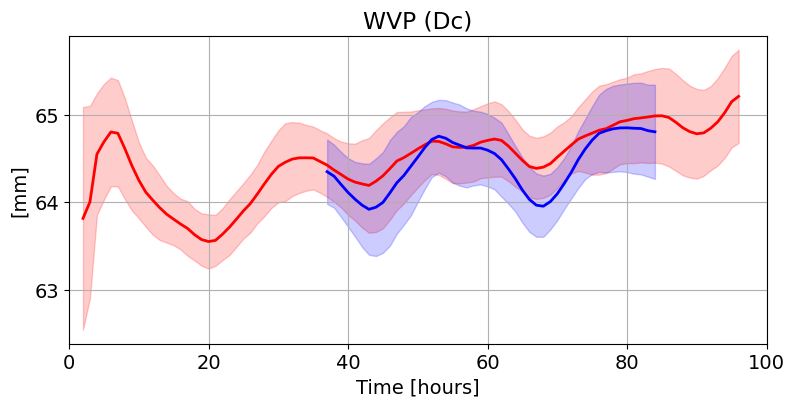

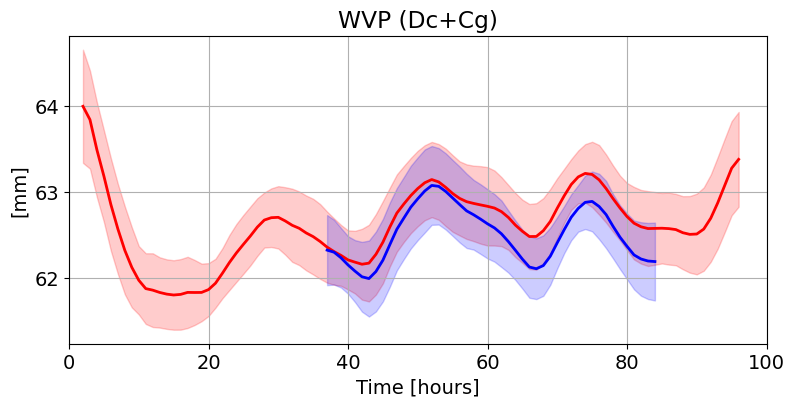

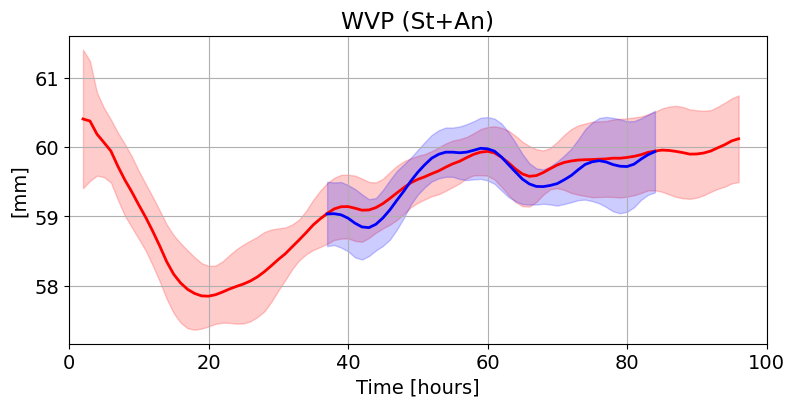

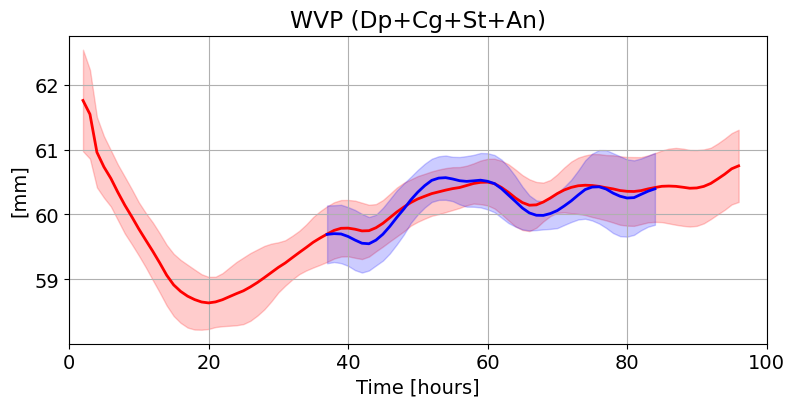

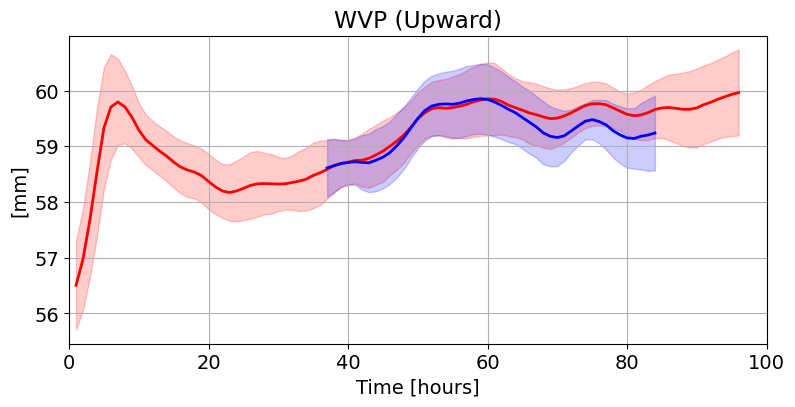

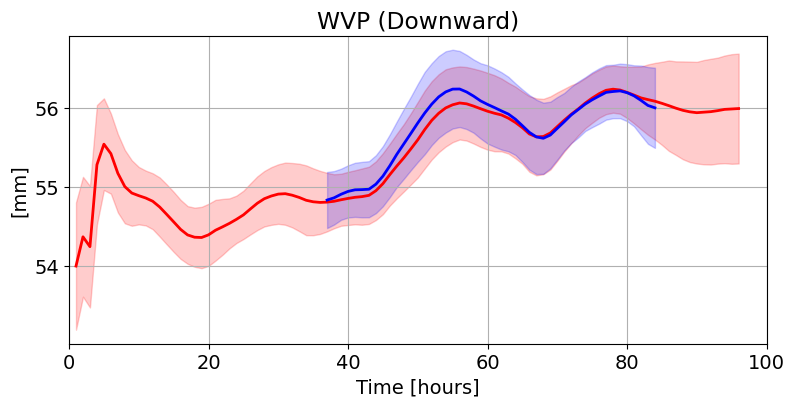

In [16]:
# ### Plotting routines

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

var_filled = np.ma.filled(var_sav, fill_value=np.nan)

for krain in range(nrain):
# for krain in range(1):

    fig_extra=krain_label[krain]
    raintag=krain_title[krain]

    var0 = var_filled[0,:,krain,:]
    var1 = var_filled[1,:,krain,:]

    for ivar in varnames:

        if ivar == 'pw':
            var0 = np.copy(var0)
            var1 = np.copy(var1)
            title_tag = 'WVP'
            ylabel = '[mm]'
            figtag = ivar
        # elif ivar == 1:

    #----------------------------------------------------------------

        var0 = pd.DataFrame(var0)
        var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
        var0 = np.copy(var0)

        var1 = pd.DataFrame(var1)
        var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
        var1 = np.copy(var1)

        # create figure
        fig = plt.figure(figsize=(9,4))
        ax = fig.add_subplot(111)

        # ax.set_title(title_tag+' ('+storm.capitalize()+'; '+raintag+')')#, fontsize=20)
        ax.set_title(title_tag+' ('+raintag+')')#, fontsize=20)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Time [hours]')

        if (ivar == 0):
            plt.ylim([-1,1])
            # if (krain ==2):
            #     plt.ylim([-1.5,-.5])
            # else:
            #     plt.ylim([-.5,.5])
        if (ivar == 5):
            if (krain == 2): plt.ylim([-50,50])

        # t_range=[30,80]
        t_range=[0,100]
        # if storm == 'maria':
        #     t_range=[40,90]

        plt.xlim(t_range)

        color_t0 = 'red'
        color_t1 = 'blue'

        # Test 0

        mean_t0 = np.nanmean(var0, axis=0)
        std_t0 = np.nanstd(var0, axis=0)

        xdim = range(nt[0])

        plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

        # Test 1

        mean_t1 = np.nanmean(var1, axis=0)
        std_t1 = np.nanstd(var1, axis=0)

        plt.plot(xdim, mean_t1, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
        plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)

        plt.grid()

        # plt.legend(loc="upper right")

        figdir2 = figdir+'all/'
        # figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'_rmax'+rmax_str+'deg.png'
        figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
        plt.savefig(figname,dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()